# **Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding**

## 1. Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?  
K-Nearest Neighbors (KNN) bisa digunakan untuk deteksi outlier karena prinsip dasarnya adalah mengukur kedekatan antara titik data dalam suatu ruang fitur. Outlier adalah titik data yang berada jauh dari mayoritas titik lain, sehingga dalam metode KNN, outlier akan memiliki tetangga yang lebih sedikit atau lebih jauh dibandingkan titik normal.

## 2. Langkah-langkah Deteksi Outlier dengan KNN
1. Menentukan Jumlah Tetangga (k)
* Nilai k (n_neighbors) menentukan seberapa banyak tetangga yang dipertimbangkan untuk menentukan apakah suatu titik adalah outlier.
* Nilai k yang terlalu kecil bisa membuat metode terlalu sensitif terhadap noise.
* Nilai k yang terlalu besar bisa membuat outlier sulit terdeteksi karena ikut dalam kelompok besar.
* Biasanya, k ditentukan dengan eksperimen atau menggunakan aturan √(jumlah data) sebagai titik awal.
2. Menerapkan Local Outlier Factor (LOF) dengan KNN
* Gunakan model Local Outlier Factor (LOF) dari sklearn.neighbors.LocalOutlierFactor.
* LOF menghitung kepadatan lokal dari setiap titik data dan membandingkannya dengan kepadatan tetangganya.
* Data dengan kepadatan yang jauh lebih rendah dibandingkan tetangga-tetangganya dianggap sebagai outlier.

## Kesimpulan
Metode KNN untuk deteksi outlier menggunakan konsep kedekatan antar titik untuk mengidentifikasi data yang berbeda secara signifikan dari yang lain. Dengan menggunakan Local Outlier Factor (LOF), kita dapat menemukan titik-titik yang memiliki kepadatan lebih rendah dibandingkan tetangganya.

In [1]:
%pip install pymysql
%pip install psycopg2


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Code diatas untuk menginstal pustaka Python PyMySQL dan Psycopg2, yang digunakan untuk menghubungkan Python dengan database:

pymysql → Untuk koneksi ke database MySQL
psycopg2 → Untuk koneksi ke database PostgreSQL

 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      4.007493        False
  2     Iris-setosa          14.0          2.0          40.9         30.0     45.789955        False
  3     Iris-setosa           1.3          0.2           4.7          3.2      4.154516        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      4.042277        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      4.047221        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      4.102438        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      3.935734        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      4.207137        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      3.968627    

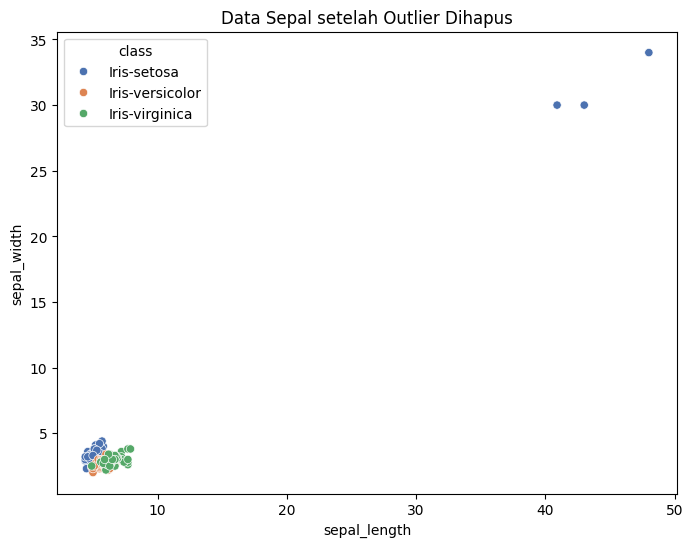

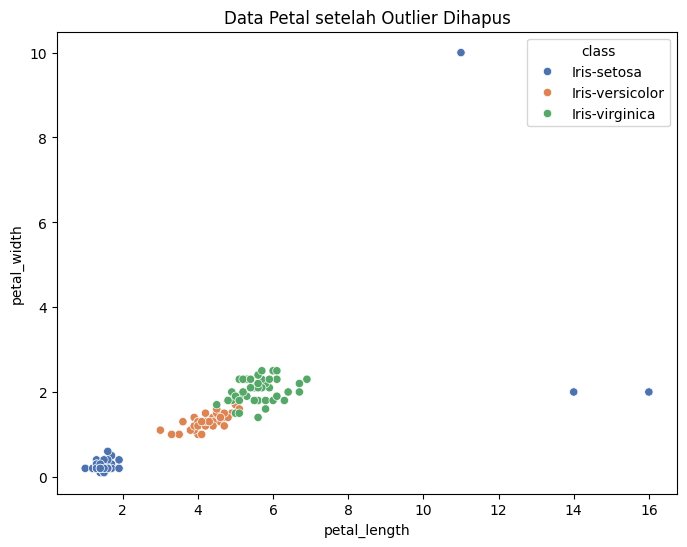

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-2784e994-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_7OwV6So2k6qKTb1yXO0",
        database="defaultdb",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel2")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-a971b40-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_xWwDDfEtRsiv7WGcUgO",
        database="irish",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel1")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=90)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Hapus data outlier
df_filtered = df_merged[~df_merged["outlier_knn"]]

# Cetak hasil setelah outlier dihapus
print(df_filtered.to_string(index=False))
print(f"\nJumlah data setelah outlier dihapus: {len(df_filtered)}")

# Visualisasi setelah outlier dihapus
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["sepal_length"], y=df_filtered["sepal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Sepal setelah Outlier Dihapus")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["petal_length"], y=df_filtered["petal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Petal setelah Outlier Dihapus")
plt.show()

## **Memisahkan outlier dari data**

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-2784e994-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_7OwV6So2k6qKTb1yXO0",
        database="defaultdb",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel2")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-a971b40-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_xWwDDfEtRsiv7WGcUgO",
        database="irish",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel1")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa           1.4          0.2           5.1          3.5              1
  2     Iris-setosa          14.0          2.0          40.9         30.0             -1
  3     Iris-setosa           1.3          0.2           4.7          3.2              1
  4     Iris-setosa           1.5          0.2           4.6          3.1              1
  5     Iris-setosa           1.4          0.2           5.0          3.6              1
  6     Iris-setosa          17.0          4.0          54.0         39.0             -1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1           4.9          3.1              1
 11     Iris-setosa  

Kode di atas bertujuan untuk mendeteksi dan memisahkan outlier dari dataset yang diambil dari dua sumber basis data, yaitu PostgreSQL dan MySQL. Proses diawali dengan melakukan koneksi ke kedua basis data menggunakan pustaka psycopg2 untuk PostgreSQL dan pymysql untuk MySQL, lalu mengeksekusi query untuk mengambil seluruh data dari tabel "iris_postgresql" dan "irismysql". Data yang diperoleh kemudian dikonversi menjadi DataFrame menggunakan pandas, dan kedua dataset digabungkan berdasarkan kolom "id" dan "class" dengan metode inner join, sehingga hanya data yang terdapat di kedua tabel yang akan dipertahankan. Selanjutnya, hanya fitur numerik yang digunakan sebagai masukan untuk model deteksi outlier, yaitu "petal_length", "petal_width", "sepal_length", dan "sepal_width". Model Local Outlier Factor (LOF) dari scikit-learn kemudian diterapkan dengan parameter n_neighbors=90, yang berarti setiap titik data dibandingkan dengan 90 tetangga terdekatnya untuk menentukan apakah titik tersebut merupakan outlier atau bukan. LOF akan memberikan label 1 untuk data yang dianggap normal dan -1 untuk data yang terdeteksi sebagai outlier. Setelah model LOF diterapkan, hasil label outlier ditambahkan ke dalam DataFrame dengan nama kolom "outlier_label", kemudian jumlah total outlier dihitung berdasarkan banyaknya data yang memiliki label -1. Dataset kemudian dibagi menjadi dua bagian, yaitu data normal (tidak outlier) yang memiliki label 1 dan disimpan dalam variabel df_filtered, serta data outlier yang memiliki label -1 dan disimpan dalam variabel outliers. Hasil deteksi outlier kemudian dicetak dengan menampilkan seluruh dataset yang telah diberi label outlier, jumlah total data yang dikategorikan sebagai outlier, serta daftar data yang dianggap sebagai outlier dan data yang tetap setelah proses pembersihan. Dengan pendekatan ini, outlier dapat diidentifikasi dan dihapus dari dataset sebelum analisis lebih lanjut dilakukan, sehingga meningkatkan kualitas data dan mengurangi potensi bias yang dapat memengaruhi hasil prediksi atau klasifikasi dalam model pembelajaran mesin.

## **Menghitung Akurasi dari data**

In [ ]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9333333333333333
                 precision    recall  f1-score   support

    Iris-setosa       0.83      1.00      0.91        10
Iris-versicolor       1.00      0.89      0.94         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30

Akurasi tanpa outlier: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



Kode di atas bertujuan untuk membandingkan akurasi dan hasil klasifikasi model K-Nearest Neighbors (KNN) pada dataset yang mengandung outlier dan yang telah dibersihkan dari outlier. Proses diawali dengan memisahkan fitur numerik yang akan digunakan dalam pemodelan dari DataFrame yang telah digabungkan sebelumnya, serta mengonversi label kelas ke dalam bentuk numerik menggunakan LabelEncoder. Model Local Outlier Factor (LOF) diterapkan kembali dengan parameter n_neighbors=90 dan contamination=0.1, yang berarti sekitar 10% dari data akan dianggap sebagai outlier. Hasil deteksi outlier ditambahkan ke DataFrame, dan dataset dibagi menjadi dua kelompok: data asli yang masih mengandung outlier serta data yang telah dibersihkan dari outlier. Selanjutnya, kedua dataset dibagi menjadi data training (80%) dan testing (20%) menggunakan train_test_split, sehingga tersedia dua set pelatihan dan pengujian—satu dengan outlier dan satu tanpa outlier. Model KNN dengan jumlah tetangga 11 diterapkan menggunakan Pipeline, yang pertama-tama menstandarkan data dengan StandardScaler sebelum melatih model KNN. Model pertama dilatih menggunakan data yang masih mengandung outlier, dan hasil prediksi pada data uji dibandingkan dengan label aslinya untuk menghitung akurasi serta menampilkan classification report, yang mencakup metrik seperti presisi, recall, dan F1-score untuk setiap kelas. Proses yang sama kemudian dilakukan pada dataset yang telah dibersihkan dari outlier. Hasil akhir dari kode ini adalah dua nilai akurasi: satu untuk model yang dilatih pada data dengan outlier dan satu untuk model yang dilatih pada data tanpa outlier. Selain itu, laporan klasifikasi juga diperlihatkan untuk menilai dampak kehadiran outlier terhadap performa model. Secara umum, model yang dilatih pada data tanpa outlier diharapkan memiliki akurasi lebih tinggi karena outlier dapat menyebabkan distorsi dalam perhitungan jarak pada KNN, yang mengakibatkan prediksi yang kurang akurat. Dengan membandingkan kedua hasil ini, pengguna dapat memahami sejauh mana pengaruh outlier terhadap performa klasifikasi dan apakah proses pembersihan data berdampak positif pada akurasi model.

## Visualisasi data

Akurasi: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



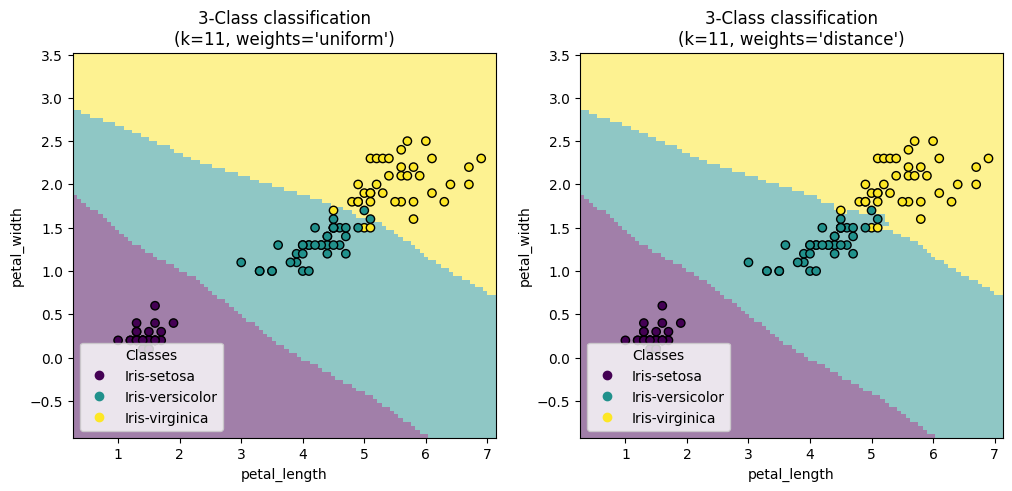

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Akurasi: 0.8888888888888888
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.83      0.71      0.77         7
 Iris-virginica       0.78      0.88      0.82         8

       accuracy                           0.89        27
      macro avg       0.87      0.86      0.86        27
   weighted avg       0.89      0.89      0.89        27



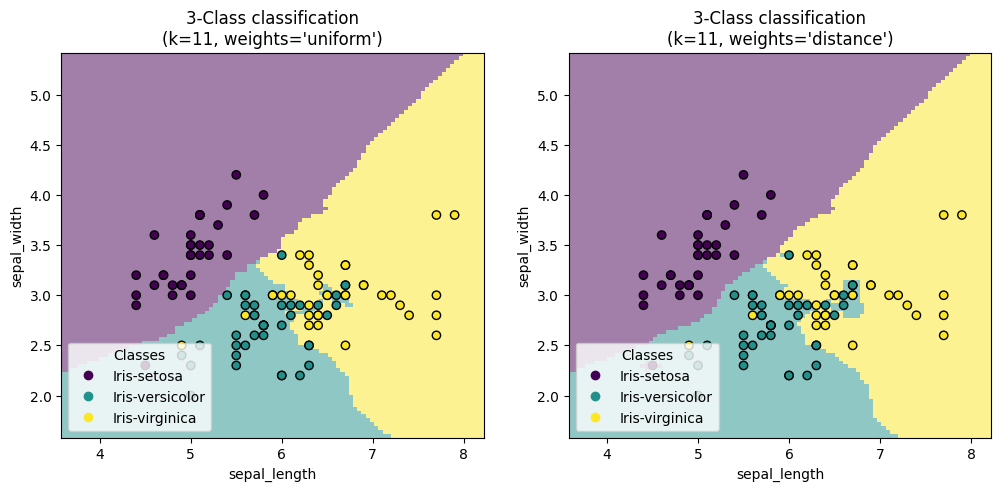

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay


# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()


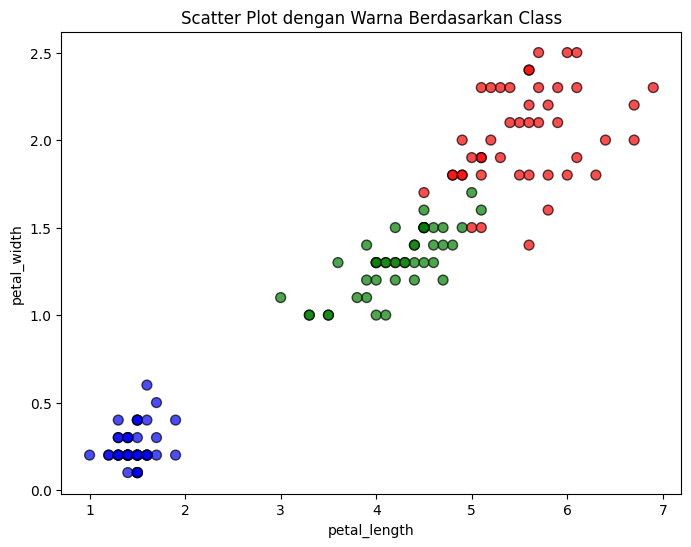

In [ ]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

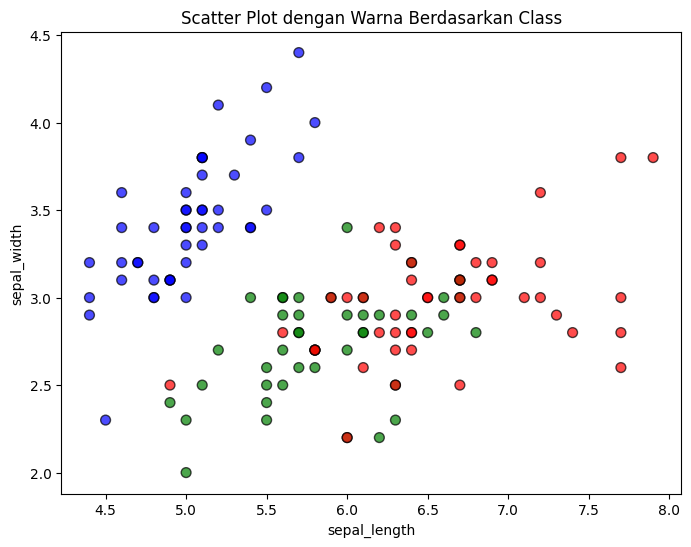

In [ ]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "sepal_length"
y_feature = "sepal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()